# 25/04/2019 Update
Please check out my  [new embedding model](https://www.kaggle.com/benjibb/entity-embedding-neural-network), which I think is more promising than the existing method.

# 07/05/2017 Update

This project is based on my [GitHub link][1] and my research is based on  [this paper][2]. 

Instead of using Echo state network which was used in the Stanford research paper, we are going to use LSTM which is more advanced in training the neural network.

More updates will be provided to accommodate the dataset in this Kaggle challenge.  You can simply adjust it to choose your features and window for data.

Thank you all!

# Import module first


  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data
  [2]: http://cs229.stanford.edu/proj2012/BernalFokPidaparthi-FinancialMarketTimeSeriesPredictionwithRecurrentNeural.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Using TensorFlow backend.


# Read data and transform them to pandas dataframe

In [2]:
df = pd.read_csv("../input/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [3]:
df2 = pd.read_csv("../input/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,197000000.0,1.285000e+09,4.830000e+08,-1.571000e+09,-1.876000e+09,2.050000e+09,-1.876000e+09,-4.084000e+09,1.124000e+09,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,11000000.0,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,660000000.0,6.750000e+08,3.799000e+09,-3.814000e+09,-1.834000e+09,1.873000e+09,-1.834000e+09,-4.489000e+09,1.560000e+09,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,481000000.0,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-146000000.0,3.080000e+09,-3.150000e+08,-2.911000e+09,2.882000e+09,5.420000e+08,2.882000e+09,2.882000e+09,1.771000e+09,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,601000000.0,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322

# Extract all symbols from the list

In [4]:
symbols = list(set(df.symbol))
len(symbols)

501

In [5]:
symbols[:11] # Example of what is in symbols

['AMZN',
 'DFS',
 'WFM',
 'DLR',
 'KHC',
 'AMT',
 'NDAQ',
 'BSX',
 'GOOGL',
 'FITB',
 'AEP']

# Extract a particular price for stock in symbols
Use GOOG as an example

In [6]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


# Normalize the data

In [7]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.157047,0.161167,0.156390,0.131722,0.159399
2010-01-05,0.157238,0.158884,0.154995,0.202469,0.157092
2010-01-06,0.156140,0.146049,0.153341,0.268184,0.143942
2010-01-07,0.142436,0.134457,0.140094,0.432522,0.132105
2010-01-08,0.127950,0.131464,0.134455,0.318492,0.138726


# Create training set and testing set

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Build the structure of model

Based on my hyperparameter testing on [here][1]. I found that these parameters are the most suitable for this task.

![dropout = 0.3][2]
![epochs = 90][3]
![LSTM 256 > LSTM 256 > Relu 32 > Linear 1][4]



  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data
  [2]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/dropout.png?raw=true
  [3]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/epochs2.png?raw=true
  [4]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/blob/master/neurons.png?raw=true

In [9]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# Train the model

In [10]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.15704696 0.16116746 0.15638998 0.1317225  0.15939908]
 [0.15723843 0.15888449 0.15499506 0.20246902 0.15709185]
 [0.15613951 0.14604929 0.15334121 0.26818406 0.14394234]
 [0.14243617 0.13445699 0.14009362 0.43252209 0.13210528]
 [0.12795029 0.13146379 0.13445546 0.3184921  0.13872603]
 [0.13832355 0.1356323  0.13546617 0.48640628 0.1379653 ]
 [0.13265404 0.13052526 0.13020388 0.3271972  0.12907917]
 [0.11503787 0.1186032  0.12203482 0.43807453 0.12624527]
 [0.12120685 0.12613696 0.12689613 0.2858228  0.12855249]
 [0.12906589 0.12210374 0.12636158 0.36641044 0.12031836]
 [0.11895908 0.12062405 0.12373877 0.29099208 0.12668832]
 [0.12293853 0.11977851 0.12003013 0.21906583 0.12066114]
 [0.12082392 0.1172081  0.12073176 0.42532947 0.1228095 ]
 [0.10505596 0.0855935  0.10718348 0.45857351 0.09524822]
 [0.09014547 0.08614311 0.08987641 0.29795279 0.08688037]
 [0.08296912 0.08680264 0.08964255 0.29361033 0.08890336]
 [0.08571648 0.08597403 0.08801372 0.26721945 0.08863587]
 [0.08839717 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
model = build_model([5,window,1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Compilation Time :  0.038523197174072266


In [12]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 4s 3ms/step - loss: 0.1276 - acc: 7.1023e-04 - val_loss: 0.5037 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0602 - acc: 7.1023e-04 - val_loss: 0.0353 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0329 - acc: 7.1023e-04 - val_loss: 0.1290 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0158 - acc: 7.1023e-04 - val_loss: 0.1902 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0158 - acc: 7.1023e-04 - val_loss: 0.0880 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 2s 2ms/step - loss: 0.0067 - acc: 7.1023e-04 - val_loss: 0.0303 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================]

In [13]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


# Denormalize the data

In [14]:
df = pd.read_csv("../input/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [15]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00109 MSE (0.03 RMSE)
Test Score: 0.00938 MSE (0.10 RMSE)


(0.0010917398363006667, 0.009376307392771217)

# Since the Kaggle dataset only contains a few years, the mean square error is not as small as my original model on GitHub.

With more than 40 years of data, we will get:

Train Score: 0.00006 MSE (0.01 RMSE)

Test Score: 0.00029 MSE (0.02 RMSE)

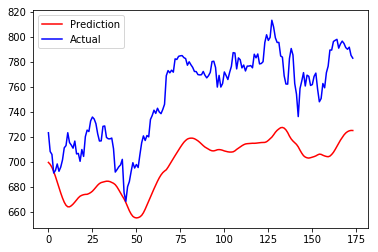

In [16]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

The result on my original model with more than 40 years of data.

![Result][1]

 Train Score: 0.00006 MSE (0.01 RMSE)

Test Score: 0.00029 MSE (0.02 RMSE)

  [1]: https://github.com/BenjiKCF/Neural-Network-with-Financial-Time-Series-Data/raw/master/result2.png

# Thank you all for reading
 If you have any question or concern, please leave a comment. Otherwise, see you next time!